In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Preprocessing for Modeling, Removing Outliers

In [38]:
train = pd.read_csv('datasets/base_train.csv')
train

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,109,533352170,60,RL,0.0,13517,Pave,None,IR1,...,0,0,None,None,None,0,3,2010,WD,130500
1,1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,...,0,0,None,None,None,0,4,2009,WD,220000
2,2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,...,0,0,None,None,None,0,1,2010,WD,109000
3,3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,...,0,0,None,None,None,0,4,2010,WD,174000
4,4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,...,0,0,None,None,None,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2046,1587,921126030,20,RL,79.0,11449,Pave,None,IR1,...,0,0,None,None,None,0,1,2008,WD,298751
2047,2047,785,905377130,30,RL,0.0,12342,Pave,None,IR1,...,0,0,None,None,None,0,3,2009,WD,82500
2048,2048,916,909253010,50,RL,57.0,7558,Pave,None,Reg,...,0,0,None,None,None,0,3,2009,WD,177000
2049,2049,639,535179160,20,RL,80.0,10400,Pave,None,Reg,...,0,0,None,None,None,0,11,2009,WD,144000


In [39]:
num_features = ['overall_qual', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', '
                fireplaces', 'garage_cars', 'garage_area', 
                 'totrms_abvgrd','lot_area', 'saleprice']      

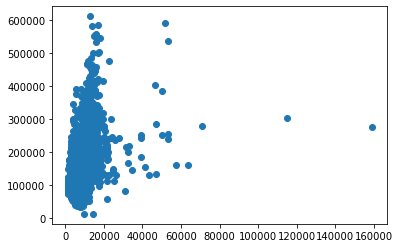

In [40]:
#Visible outliers above ~60,000
plt.scatter(train['lot_area'], train['saleprice']);

In [9]:
#removed outliers above 40_000
train = train.loc[train['lot_area' ]< 40000]

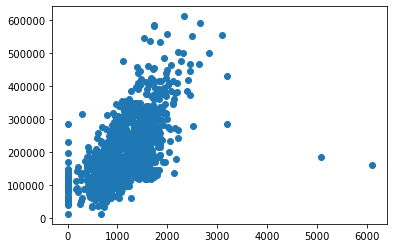

In [41]:
#visible outliers above 3000 sf
plt.scatter(train['total_bsmt_sf'], train['saleprice'])

In [11]:
#removing total bsmt sf observations abovee 3000
train = train.loc[train['total_bsmt_sf'] < 3000]

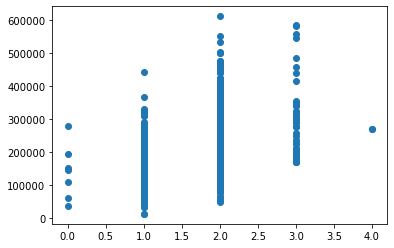

In [12]:
#need to remove that one outlier at 4
plt.scatter(train['full_bath'], train['saleprice'])

In [13]:
train = train.loc[train['full_bath'] <= 3]

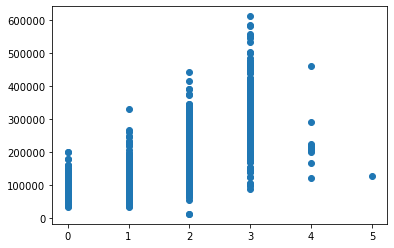

In [14]:
#need to remove that one outlier at 5
plt.scatter(train['garage_cars'], train['saleprice'])

In [15]:
train =train.loc[train['garage_cars'] <=4]

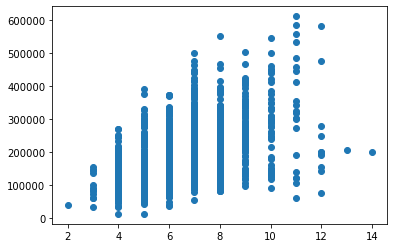

In [16]:
#need to remove the observations greater than 12
plt.scatter(train['totrms_abvgrd'], train['saleprice'])

In [17]:
train = train.loc[train['totrms_abvgrd'] <= 12]

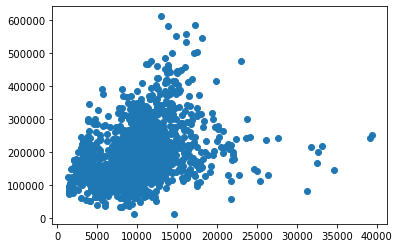

In [18]:
#after looking at lot_area again, want to remove the outliers past 30,000
plt.scatter(train['lot_area'], train['saleprice'])

In [19]:
train = train.loc[train['lot_area'] < 30_000]

In [20]:
train = train[num_features]

In [21]:
train['total_sf'] = train['1st_flr_sf'] + train['2nd_flr_sf']

In [22]:
train.head()

,overall_qual,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,full_bath,fireplaces,garage_cars,garage_area,totrms_abvgrd,lot_area,saleprice,total_sf
0,6,725.0,725,754,1479,2,0,2.0,475.0,6,13517,130500,1479
1,7,913.0,913,1209,2122,2,1,2.0,559.0,8,11492,220000,2122
2,5,1057.0,1057,0,1057,1,0,1.0,246.0,5,7922,109000,1057
3,5,384.0,744,700,1444,2,0,2.0,400.0,7,9802,174000,1444
4,6,676.0,831,614,1445,2,0,2.0,484.0,6,14235,138500,1445


In [23]:
train.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [24]:
train.shape

(2018, 11)

## Model 

In [25]:
X = train.drop(columns='saleprice')
y = train['saleprice']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y) 

In [27]:
pf = PolynomialFeatures(include_bias = False)
pf.fit(X_train)

PolynomialFeatures(include_bias=False)

In [28]:
X_train_pf = pf.transform(X_train)
X_test_pf = pf.transform(X_test)
X_test_pf = pd.DataFrame(X_test_pf, columns=pf.get_feature_names(X.columns))

In [29]:
lr_pf = LinearRegression()

In [30]:
lr_pf.fit(X_train_pf, y_train)

LinearRegression()

In [31]:
#test and train scores are now higher and very close together implying a nice bias variance tradeoff
print(lr_pf.score(X_test_pf, y_test))
print(lr_pf.score(X_train_pf, y_train))

0.8889936107451866
0.882403274527736


In [32]:
sc = StandardScaler()
sc.fit(X_test_pf)

StandardScaler()

In [33]:
X_train_sc = sc.transform(X_train_pf)
X_test_sc = sc.transform(X_test_pf)
X_train_sc = pd.DataFrame(X_train_sc, columns=pf.get_feature_names(X.columns))
X_test_sc = pd.DataFrame(X_test_sc, columns=pf.get_feature_names(X.columns))

In [34]:
lr_sc = LinearRegression()
lr_sc.fit(X_train_sc, y_train)
lr_sc.score(X_test_sc, y_test), lr_sc.score(X_train_sc, y_train)

(0.8889936107485324, 0.882403274527736)

In [36]:
#cross val scores are somewhat jumbled, however the mean is still somewhat strong
cross_val_score(lr_sc,X_test,y_test,cv=20)

array([0.78249068, 0.84070398, 0.60253754, 0.81159368, 0.82395405,
       0.81076144, 0.79886555, 0.7657808 , 0.90575532, 0.93303833,
       0.87184146, 0.80137865, 0.88693134, 0.75591071, 0.62466985,
       0.78042103, 0.75163167, 0.91759811, 0.92630242, 0.93306511])

In [37]:
#RMSE is lower than the previous model after removing the outliers
y_preds_sc = lr_sc.predict(X_train_sc)
mean_squared_error(y_train, y_preds_sc, squared=False)

26149.07872432848

## Shaping and Predicting Test 

In [148]:
test = pd.read_csv('datasets/base_test.csv')
test.drop(columns='Unnamed: 0', inplace=True)

In [150]:
num_features = ['overall_qual', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', 'fireplaces', 'garage_cars', 'garage_area', 
                 'totrms_abvgrd','lot_area']

In [151]:
test = test[num_features]

In [153]:
test['total_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']

In [155]:
test.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [157]:
test.head()

,overall_qual,total_bsmt_sf,gr_liv_area,full_bath,fireplaces,garage_cars,garage_area,totrms_abvgrd,lot_area,total_sf
0,6,1020,1928,2,0,1,440,9,9142,1928
1,5,1967,1967,2,0,2,580,10,9662,1967
2,7,654,1496,2,1,2,426,7,17104,1496
3,5,968,968,1,0,2,480,5,8520,968
4,6,1394,1394,1,2,2,514,6,9500,1394


In [158]:
test_pf = pf.transform(test)
test_pf = pd.DataFrame(test_pf, columns=pf.get_feature_names(X.columns))

In [159]:
test_sc = sc.transform(test_pf)

In [160]:
test_sc = (pd.DataFrame(test_sc, columns=pf.get_feature_names(X.columns)))

In [161]:
y_preds = lr_sc.predict(test_sc)

In [162]:
y_preds.mean()

173635.26094825857

In [163]:
df = pd.read_csv('datasets/test.csv')

In [164]:
submission = pd.DataFrame(df['Id'])
submission['SalePrice'] = y_preds

In [167]:
submission

,Id,SalePrice
0,2658,163906.026940
1,2718,161499.288939
2,2414,185709.844358
3,1989,124460.154050
4,625,189683.753638
...,...,...
873,1662,189864.059264
874,1234,207712.250594
875,1373,133372.325888
876,1672,106084.747277


In [168]:
submission.to_csv('submission_c.csv', index=False)